In [31]:
import homophily_multi_attr_viz as viz
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Analytical Approach 

This notebook explores the social origin networks published in he paper titled "The Social Origins of Networks and Diffusion" by Centola (available at https://www.jstor.org/stable/10.1086/681275). 

The goal is do describe this approach in a marginal matrix and multidimensional composite affinity matrix. This allows us to compare the two network-generation approaches and sheds light on how they differ. 

## Marginal Matrix

As described in the paper, each node gets randomly assigned an attribute in the first dimension. The correlation between an individual’s social positions across dimensions is modeled by assigning an individual’s social positions in $h_2 \dots h_H$ at distance $y$ from her position in $h_1$ with the probability 
$$
p_c(y) = ce^{-\beta y}
$$

Where $\beta$ is a tunable social consolidation parameter, and c is a normalizing constant.


Because we only consider 2 dimensions with 2 attributes the probaility of getting a node with attribute 0,0 written as $p_m(0,0)$, boils down to the following: 

$$
p_m(0,0) = p_m(1,1) = 0.5 c e^{-\beta} \\
p_m(0,1) = p_m(1,0) = 0.5 c e^{-2\beta}
$$

We are only interested in the normalized version: 

$$
p_m(0,0) = p_m(1,1) = \tilde{c} \\
p_m(0,1) = p_m(1,0) =  \tilde{c} e^{-\beta}
$$

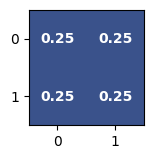

In [32]:
# analytical solution
a = 1
b = 0

def marginal_matrix(a,b): 
    marginal_matrix = np.array([[1, np.exp(-b)],
                                [np.exp(-b), 1]]).reshape(2, 2)
    marginal_matrix = marginal_matrix / marginal_matrix.sum()

    return marginal_matrix

m = marginal_matrix(a,b)

viz.fig_colored_matrix(
            m,
            xticks=range(2),
            yticks=range(2),
            show_colorbar=False,
            figsize=None,
            vmin=0)
plt.show()

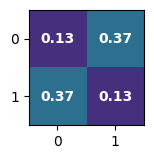

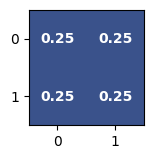

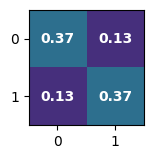

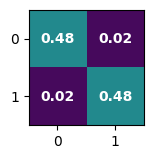

In [33]:
beta_settings = [-1, 0, 1, 3]

for b in beta_settings: 
    m = marginal_matrix(a,b)

    viz.fig_colored_matrix(
            m,
            xticks=range(2),
            yticks=range(2),
            show_colorbar=False,
            figsize=None,
            vmin=0)
    plt.show()

## Multidimensional composite affinity matrix

The social origins model models homophily with the following method. 

The probability that a social tie will form between individuals $i$ and $j$ increases with their social proximity. This is modeled by choosing an individual $i$ at random and a distance $x$ with probability 
$$
p_h(x) = ce^{-\alpha x}
$$
Where $\alpha$ is a tunable parameter that controls homophily, and $c$ is a normalizing constant. A node $j$ is then chosen randomly from among all nodes at distance $x$ from $i$. This process is repeated until a network is constructed. 

Similarly to before, we can reduce this to two dimension and attributes. 
We need to trick a bit to get it to the same form. What does this matrix actually tell us?
If two nodes are selected by random, what is the probability that we connect them! One interesting fact on this, if we multiply the entire matrix by a constant we will get the same network (or at least with the same characteristics), as we will reject less in all cases. 
So we don't need to worry about the absolute value and only consider the relatives to each other. 

To get from the algorithm above, where we selcte one node and the second one based on the distance and connect those (as long as the link does not yet exist) to one where we select two nodes and connect them based on some probabilty, we will rewrite it in an alternative way. 

1. Randomly select Node n1
2. Randomly select Node n2
3. Connect them with the probability that n2 would be selected in algo 1 (probability that this distance would be selected divided by the number of nodes satisfying this distance)
$$
p(n1 \leftrightarrow n2) = \frac{p_h(x = distance(n1, n2))}{|\{n \in N | distance(n1,n2) = distance(n, n1)\}|} 
$$


The distance between two nodes is defined as the minimum distance through all dimensions. Therefore the nodes 0,0 and 0,1 have a distance of 1 whereas 0,0 and 1,1 have a distance of 2. 

We can calculate this probability for all possible groups. We need to consider both directions, as we are working with an undirected network.

$$
\begin{align*}
p(0,0 \leftrightarrow 0,0) &= p_h(1) \cdot \frac{1}{|N| \cdot (p_m(0,0) + p_m(0,1) + p_m(1,0))} \cdot 2 \\
p(0,0 \leftrightarrow 0,1) &= p_h(1) \cdot \frac{1}{|N| \cdot (p_m(0,0) + p_m(0,1) + p_m(1,0))} \\
&\quad+ p_h(1) \cdot \frac{1}{|N| \cdot (p_m(0,0) + p_m(0,1) + p_m(1,1))} \\
p(0,0 \leftrightarrow 1,1) &= p_h(2) \cdot \frac{1}{|N| \cdot (p_m(1,1))} + p_h(2) \cdot \frac{1}{|N| \cdot (p_m(0,0))} \\
\dots
\end{align*}
$$

We can reduce this to the following: 
$$
\begin{align*}
p(0,0 \leftrightarrow 0,0) = p(1,1 \leftrightarrow 1,1) &= \frac{2}{1 + 2e^{-b}} \\
p(0,0 \leftrightarrow 0,1) = p(0,0 \leftrightarrow 1,0) &= p(1, 1 \leftrightarrow 0,1) = p(1,1 \leftrightarrow 1,0) \\
&= \frac{1}{1+ 2e^{-b}} + \frac{1}{2+ e^{-b}} \\
p(0,0 \leftrightarrow 1,1) &= 2 e^{-a} \\
\\
p(0,1 \leftrightarrow 0,1) = p(1,0 \leftrightarrow 1,0) &= \frac{2}{2 + e^{-b}} \\
\\
p(0,1 \leftrightarrow 1,0) &= \frac{2 e^{-a}}{e^{-b}}
\end{align*}
$$


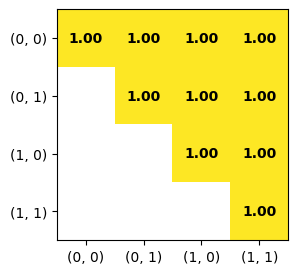

In [17]:
a = np.log(3)
b = 0

def homophily_matrix(a,b):
    # homophily matrix filled with NaNs
    h_matrix = np.full((4, 4), np.nan, dtype=np.float32)
    d1 = 1
    d2 = np.exp(-a) * d1

    m = marginal_matrix(a,b)

    h_matrix[0, 0] = d1 * 1/(m[0,0] + m[1, 0] + m[0,1]) * 2
    h_matrix[0, 1] = h_matrix[0, 2] = d1 * (1/(m[0,0] + m[1, 0] + m[0,1]) + 1/(m[1,1] + m[0,1] + m[0,0]))
    h_matrix[0, 3] = d2 / m[0,0] * 2

    h_matrix[1, 1] = d1 * 1/(m[0,0] + m[1, 0] + m[1,1]) * 2
    h_matrix[1, 2] = d2 / m[1,0] * 2
    h_matrix[1, 3] = h_matrix[0,1]

    h_matrix[2, 2] = h_matrix[1,1]
    h_matrix[2, 3] = h_matrix[0,1]

    h_matrix[3, 3] = h_matrix[0,0]


    h_matrix = h_matrix / np.nanmax(h_matrix)

    return h_matrix


h_matrix = homophily_matrix(a,b)

viz.fig_colored_matrix(
            h_matrix,
            xticks=itertools.product(range(2), repeat=2),
            yticks=itertools.product(range(2), repeat=2),
            show_colorbar=False,
            figsize=None,
            vmin=0)
plt.show()

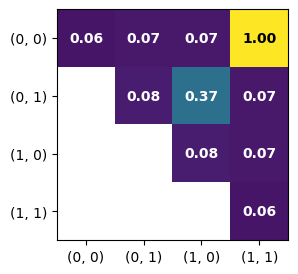

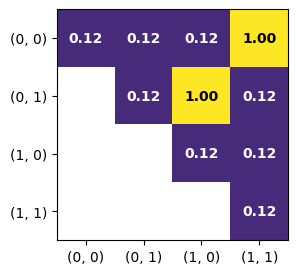

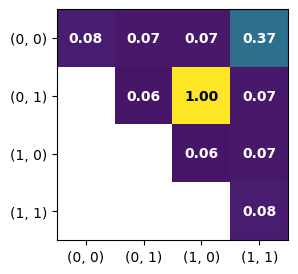

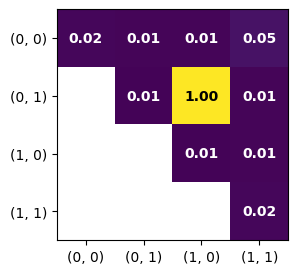

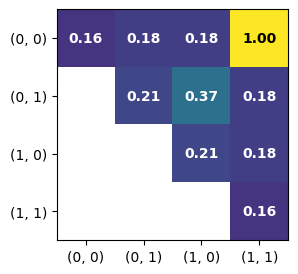

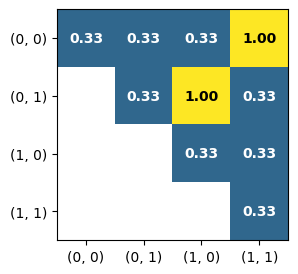

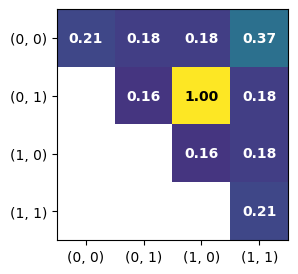

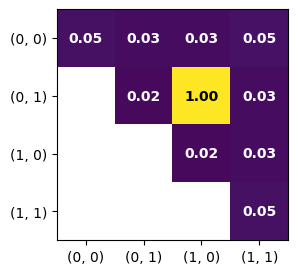

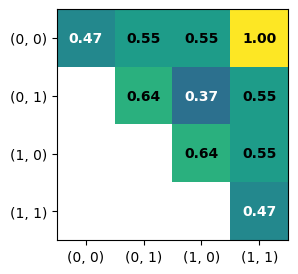

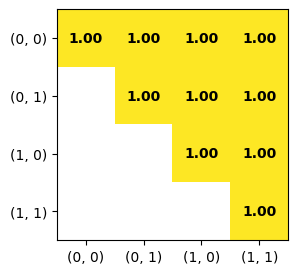

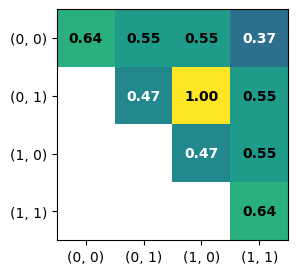

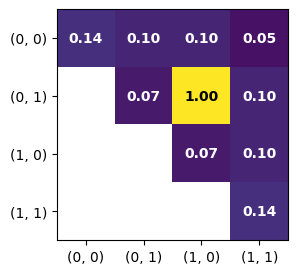

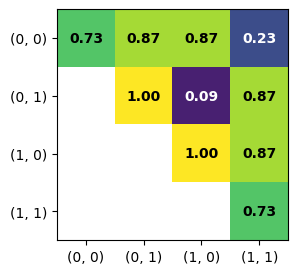

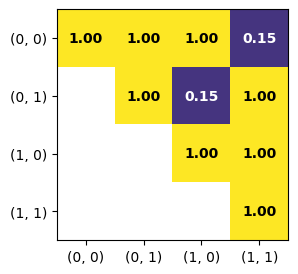

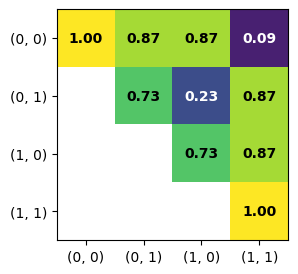

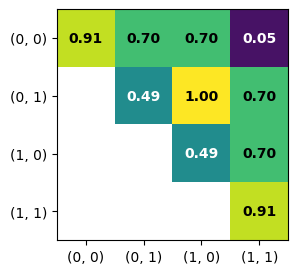

In [24]:
alpha_settings = [-1, 0, np.log(3), 3]
beta_settings = [-1, 0, 1, 3]

for a in alpha_settings:
    for b in beta_settings: 
        h_matrix = homophily_matrix(a,b)

        viz.fig_colored_matrix(
                    h_matrix,
                    xticks=itertools.product(range(2), repeat=2),
                    yticks=itertools.product(range(2), repeat=2),
                    show_colorbar=False,
                    figsize=None,
                    vmin=0)
        plt.show()

## Using Max Distnace instead of Min

The definition of distance between two nodes in the original paper is the minimum distance through all dimension. Because we used affinity in all dimensions in our other approach, this turns out to be really different. Therefore I looked how it would behave if we used the max distance in all dimension.

We can reduce this to the following: 
$$
\begin{align*}
p(0,0 \leftrightarrow 0,0) = p(1,1 \leftrightarrow 1,1) &= 1 \\
p(0,0 \leftrightarrow 0,1) = p(0,0 \leftrightarrow 1,0) &= p(1, 1 \leftrightarrow 0,1) = p(1,1 \leftrightarrow 1,0) \\
&= e^{-a} \cdot (\frac{1}{1+ 2e^{-b}} + \frac{1}{2+ e^{-b}})\\
p(0,0 \leftrightarrow 1,1) &= \frac{2 e^{-a}}{1 + 2e^{-b}} \\
\\
p(0,1 \leftrightarrow 0,1) = p(1,0 \leftrightarrow 1,0) &= \frac{2}{e^{-b}} \\
\\
p(0,1 \leftrightarrow 1,0) &= \frac{2 e^{-a}}{2+e^{-b}}
\end{align*}
$$


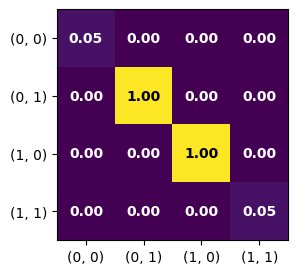

In [18]:
a = 3
b = 3

h_matrix = np.zeros((4, 4))
d1 = 1
d2 = np.exp(-a) * d1

m = marginal_matrix(a,b)

h_matrix[0, 0] = d1 * 2 / m[0,0]
h_matrix[0, 1] = h_matrix[0, 2] = d2 * (1/(m[0,0] + m[1, 0] + m[0,1]) + 1/(m[1,1] + m[0,1] + m[0,0]))
h_matrix[0, 3] = d2 * 1/(m[1, 1] + m[1, 0] + m[0, 1]) * 2

h_matrix[1, 1] = d1 * 1/(m[0,1]) * 2
h_matrix[1, 2] = d2 * 1/(m[0,1] + m[0,0] + m[1,1])* 2
h_matrix[1, 3] = h_matrix[0,1]

h_matrix[2, 2] = h_matrix[1,1]
h_matrix[2, 3] = h_matrix[0,1]

h_matrix[3, 3] = h_matrix[0,0]

h_matrix = h_matrix / h_matrix.max()


viz.fig_colored_matrix(
            h_matrix,
            xticks=itertools.product(range(2), repeat=2),
            yticks=itertools.product(range(2), repeat=2),
            show_colorbar=False,
            figsize=None,
            vmin=0)
plt.show()

## For arbitrary complexity in 2 dimensions

In [19]:
import itertools
import math
import numpy as np

a = 1.5
b = 2

def attribute_dist(H = 2):
    max_dist = math.ceil(np.log2(H)) + 1
    def attributes_dist(a1, a2):
        for i in range(max_dist - 1, -1, -1):
            if a1//(2**i) != a2//(2**i):
                return i + 2
        return 1

    attribute_dist_matrix = np.zeros((H, H), dtype=np.int16)
    for i in range(H):
        for j in range(H):
            attribute_dist_matrix[i, j] = attributes_dist(i, j)
    return attribute_dist_matrix

def marginal_matrix(a,b, H = 2): 
    D = 2

    max_dist = math.ceil(np.log2(H)) + 1
    attribute_dist_matrix = attribute_dist(H)

    marginal_matrix = np.zeros((H, H), dtype=np.float32)
    for d in range(max_dist):
        prob = np.exp(-b * d)
        for i in range(H):
            same_dist = []
            for j in range(H):
                if attribute_dist_matrix[i, j] == d + 1:
                   same_dist.append(j)
            for j in same_dist:
                marginal_matrix[i, j] = prob / len(same_dist)

    return marginal_matrix / marginal_matrix.max()

mm = marginal_matrix(a,b, H = 2)

# print with 2 decimals
np.set_printoptions(precision=3)
print(mm)

[[1.    0.135]
 [0.135 1.   ]]


In [29]:
def h_matrix(a, b, H=2, dimension_aggregation = np.min):
    D = 2

    node_dist_matrix = np.zeros((H**D, H**D), dtype=np.int16)

    max_dist = math.ceil(np.log2(H)) + 1
    attribute_dist_matrix = attribute_dist(H)
    mm = marginal_matrix(a, b, H=H)

    node_dist_matrix = np.zeros((H**D, H**D), dtype=np.float32)
    for i, n1 in enumerate(itertools.product(range(H), repeat=D)):
        for j, n2 in enumerate(itertools.product(range(H), repeat=D)):
            distances = [attribute_dist_matrix[n1[k], n2[k]]
                         for k in range(D)]
            node_dist_matrix[i, j] = dimension_aggregation(distances)

    h_matrix = np.zeros((H**D, H**D), dtype=np.float32)

    for d in range(max_dist):
        prob = np.exp(-a * d)
        for i, n1 in enumerate(itertools.product(range(H), repeat=D)):
            same_dist = []
            for j, n2 in enumerate(itertools.product(range(H), repeat=D)):
                if node_dist_matrix[i, j] == d + 1:
                   same_dist.append((j, mm[n2[0], n2[1]]))

            for j, n2 in same_dist:
                h_matrix[i, j] = prob / sum([mp for _, mp in same_dist])

    
    return h_matrix + h_matrix.T

hm = h_matrix(a=1.5, b=2, H = 8)
hm = hm / hm.max()
hm

array([[0.604, 0.484, 0.474, ..., 0.002, 0.002, 0.002],
       [0.484, 0.364, 0.354, ..., 0.002, 0.002, 0.002],
       [0.474, 0.354, 0.344, ..., 0.002, 0.002, 0.002],
       ...,
       [0.002, 0.002, 0.002, ..., 0.344, 0.354, 0.474],
       [0.002, 0.002, 0.002, ..., 0.354, 0.364, 0.484],
       [0.002, 0.002, 0.002, ..., 0.474, 0.484, 0.604]], dtype=float32)

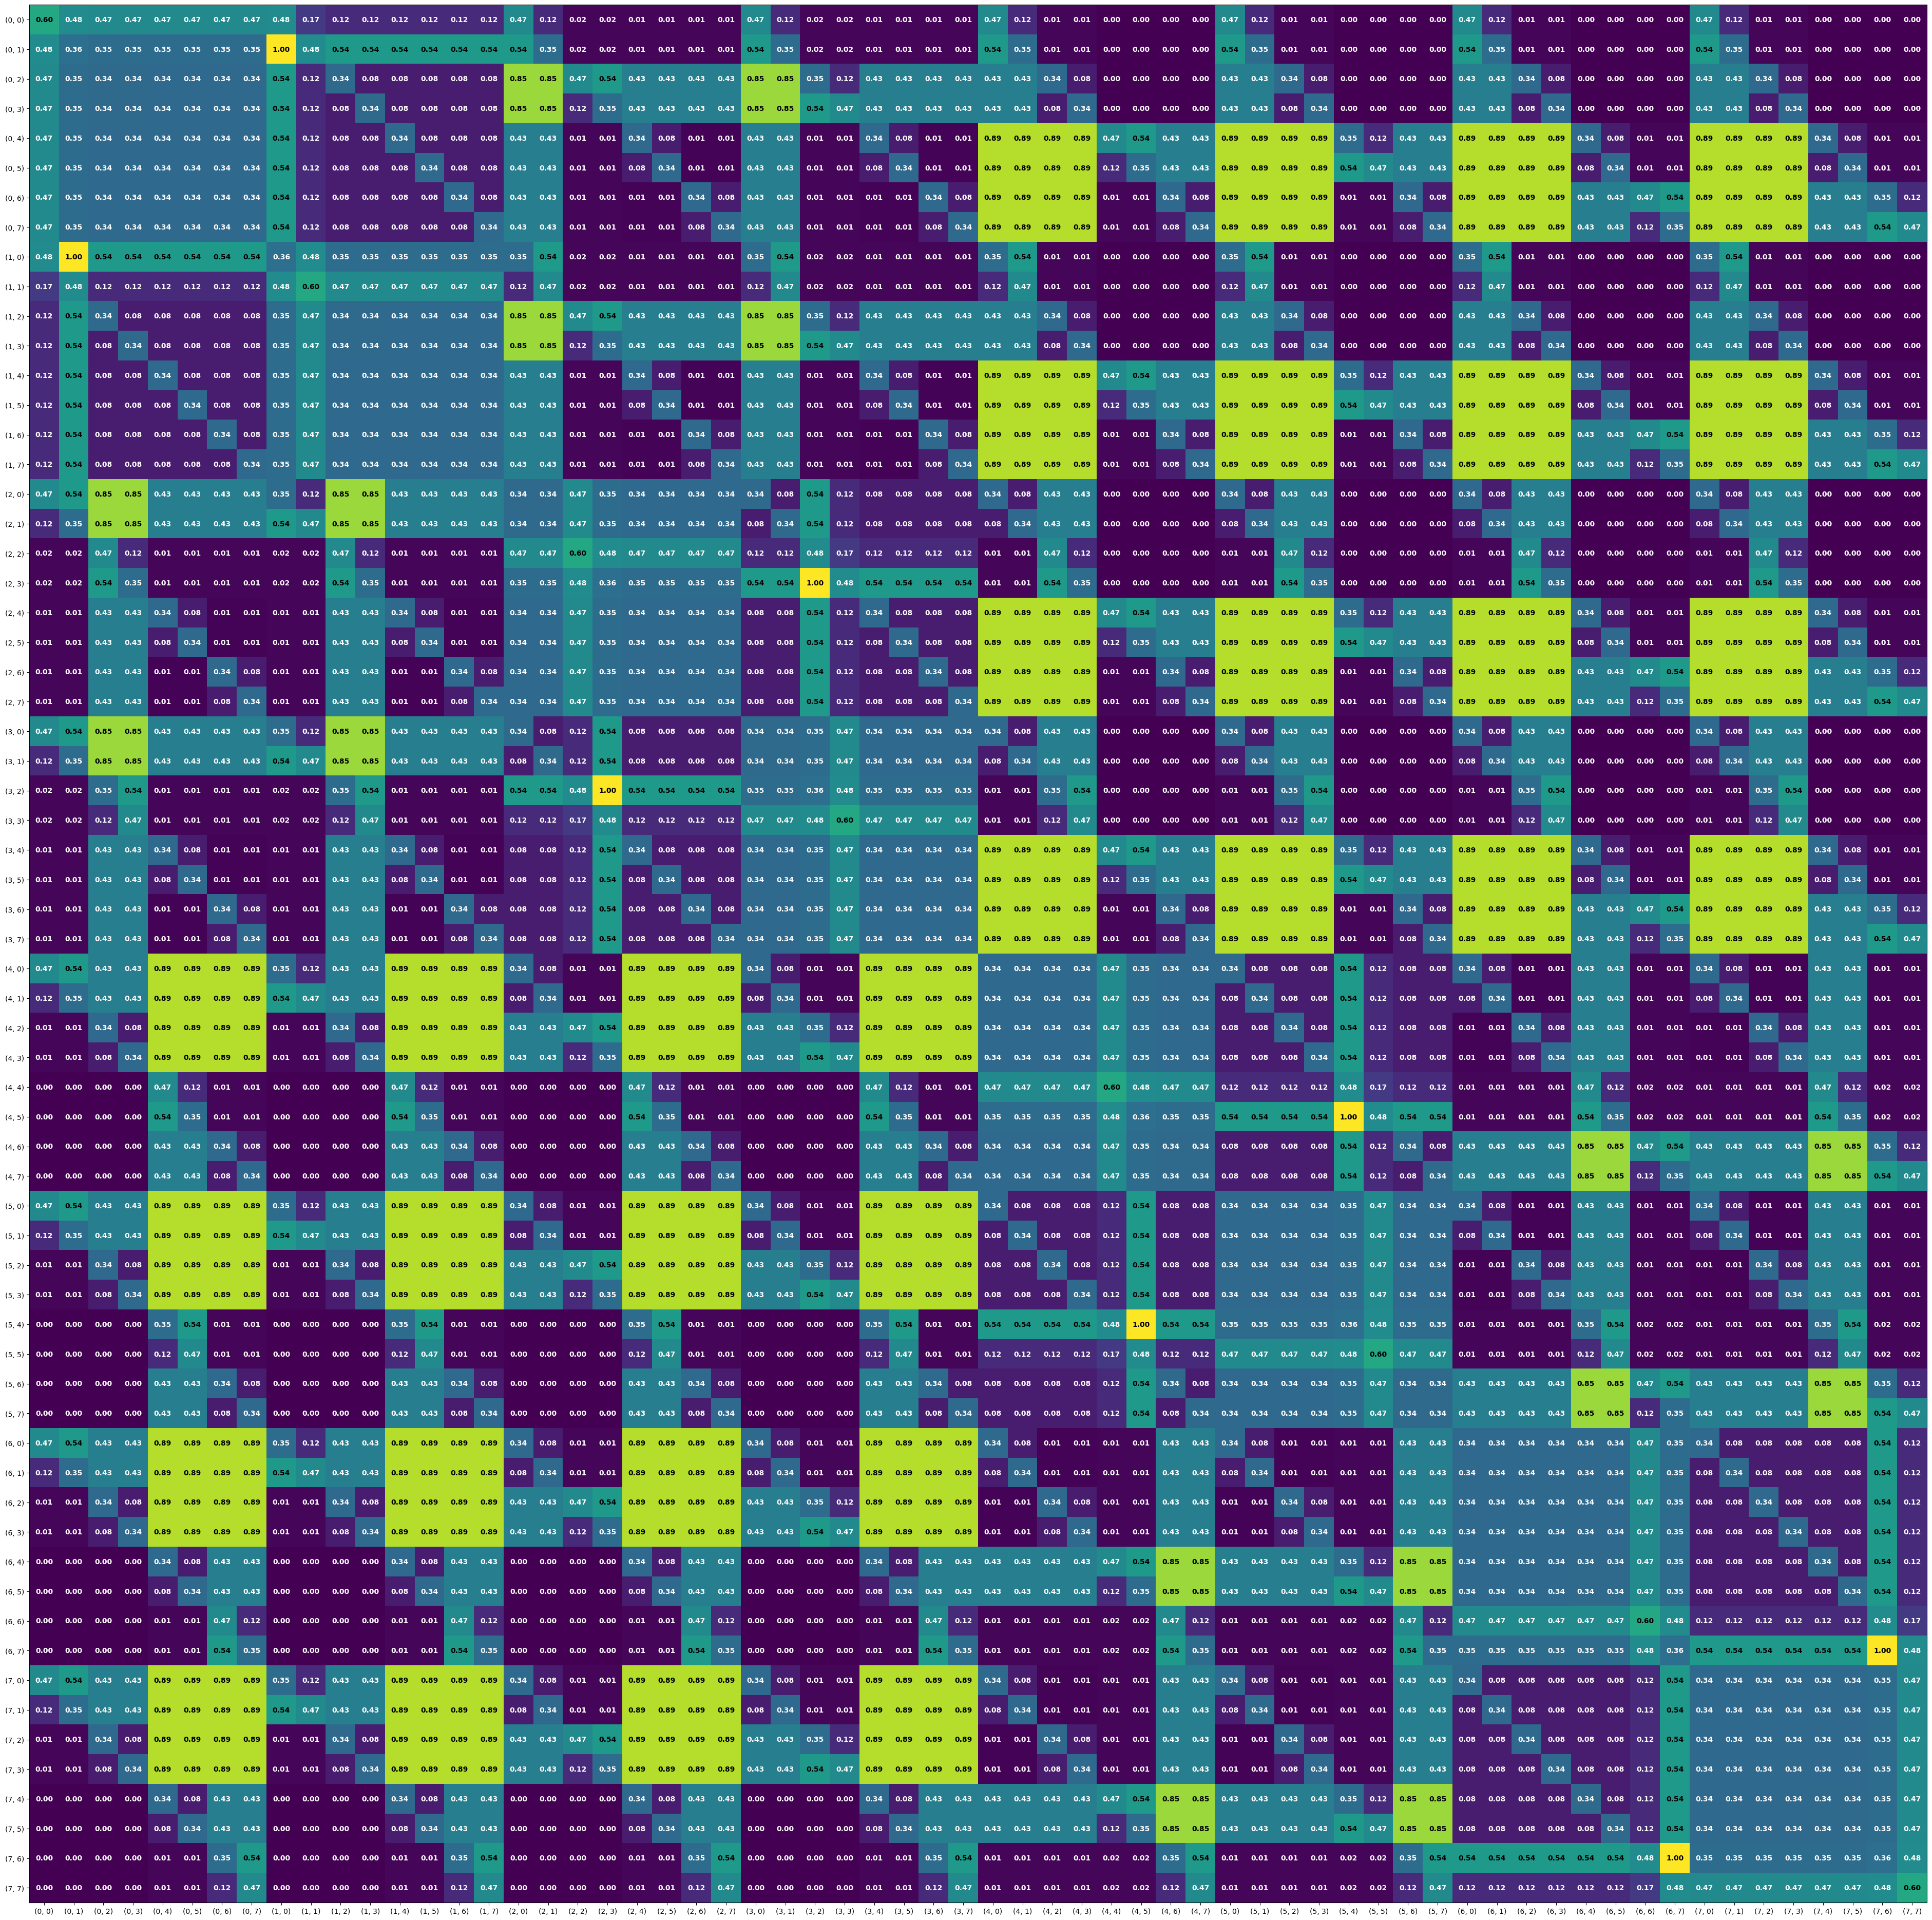

In [30]:
viz.fig_colored_matrix(
            hm,
            xticks=itertools.product(range(8), repeat=2),
            yticks=itertools.product(range(8), repeat=2),
            show_colorbar=False,
            figsize=None,
            vmin=0)
plt.show()

In [9]:
hm_rowwise = np.divide(hm, hm.max(axis=1)[:, None])
hm_rowwise

array([[1.   , 0.801, 0.785, ..., 0.003, 0.003, 0.003],
       [0.484, 0.364, 0.354, ..., 0.002, 0.002, 0.002],
       [0.559, 0.418, 0.406, ..., 0.002, 0.002, 0.002],
       ...,
       [0.002, 0.002, 0.002, ..., 0.406, 0.418, 0.559],
       [0.002, 0.002, 0.002, ..., 0.354, 0.364, 0.484],
       [0.003, 0.003, 0.003, ..., 0.785, 0.801, 1.   ]], dtype=float32)

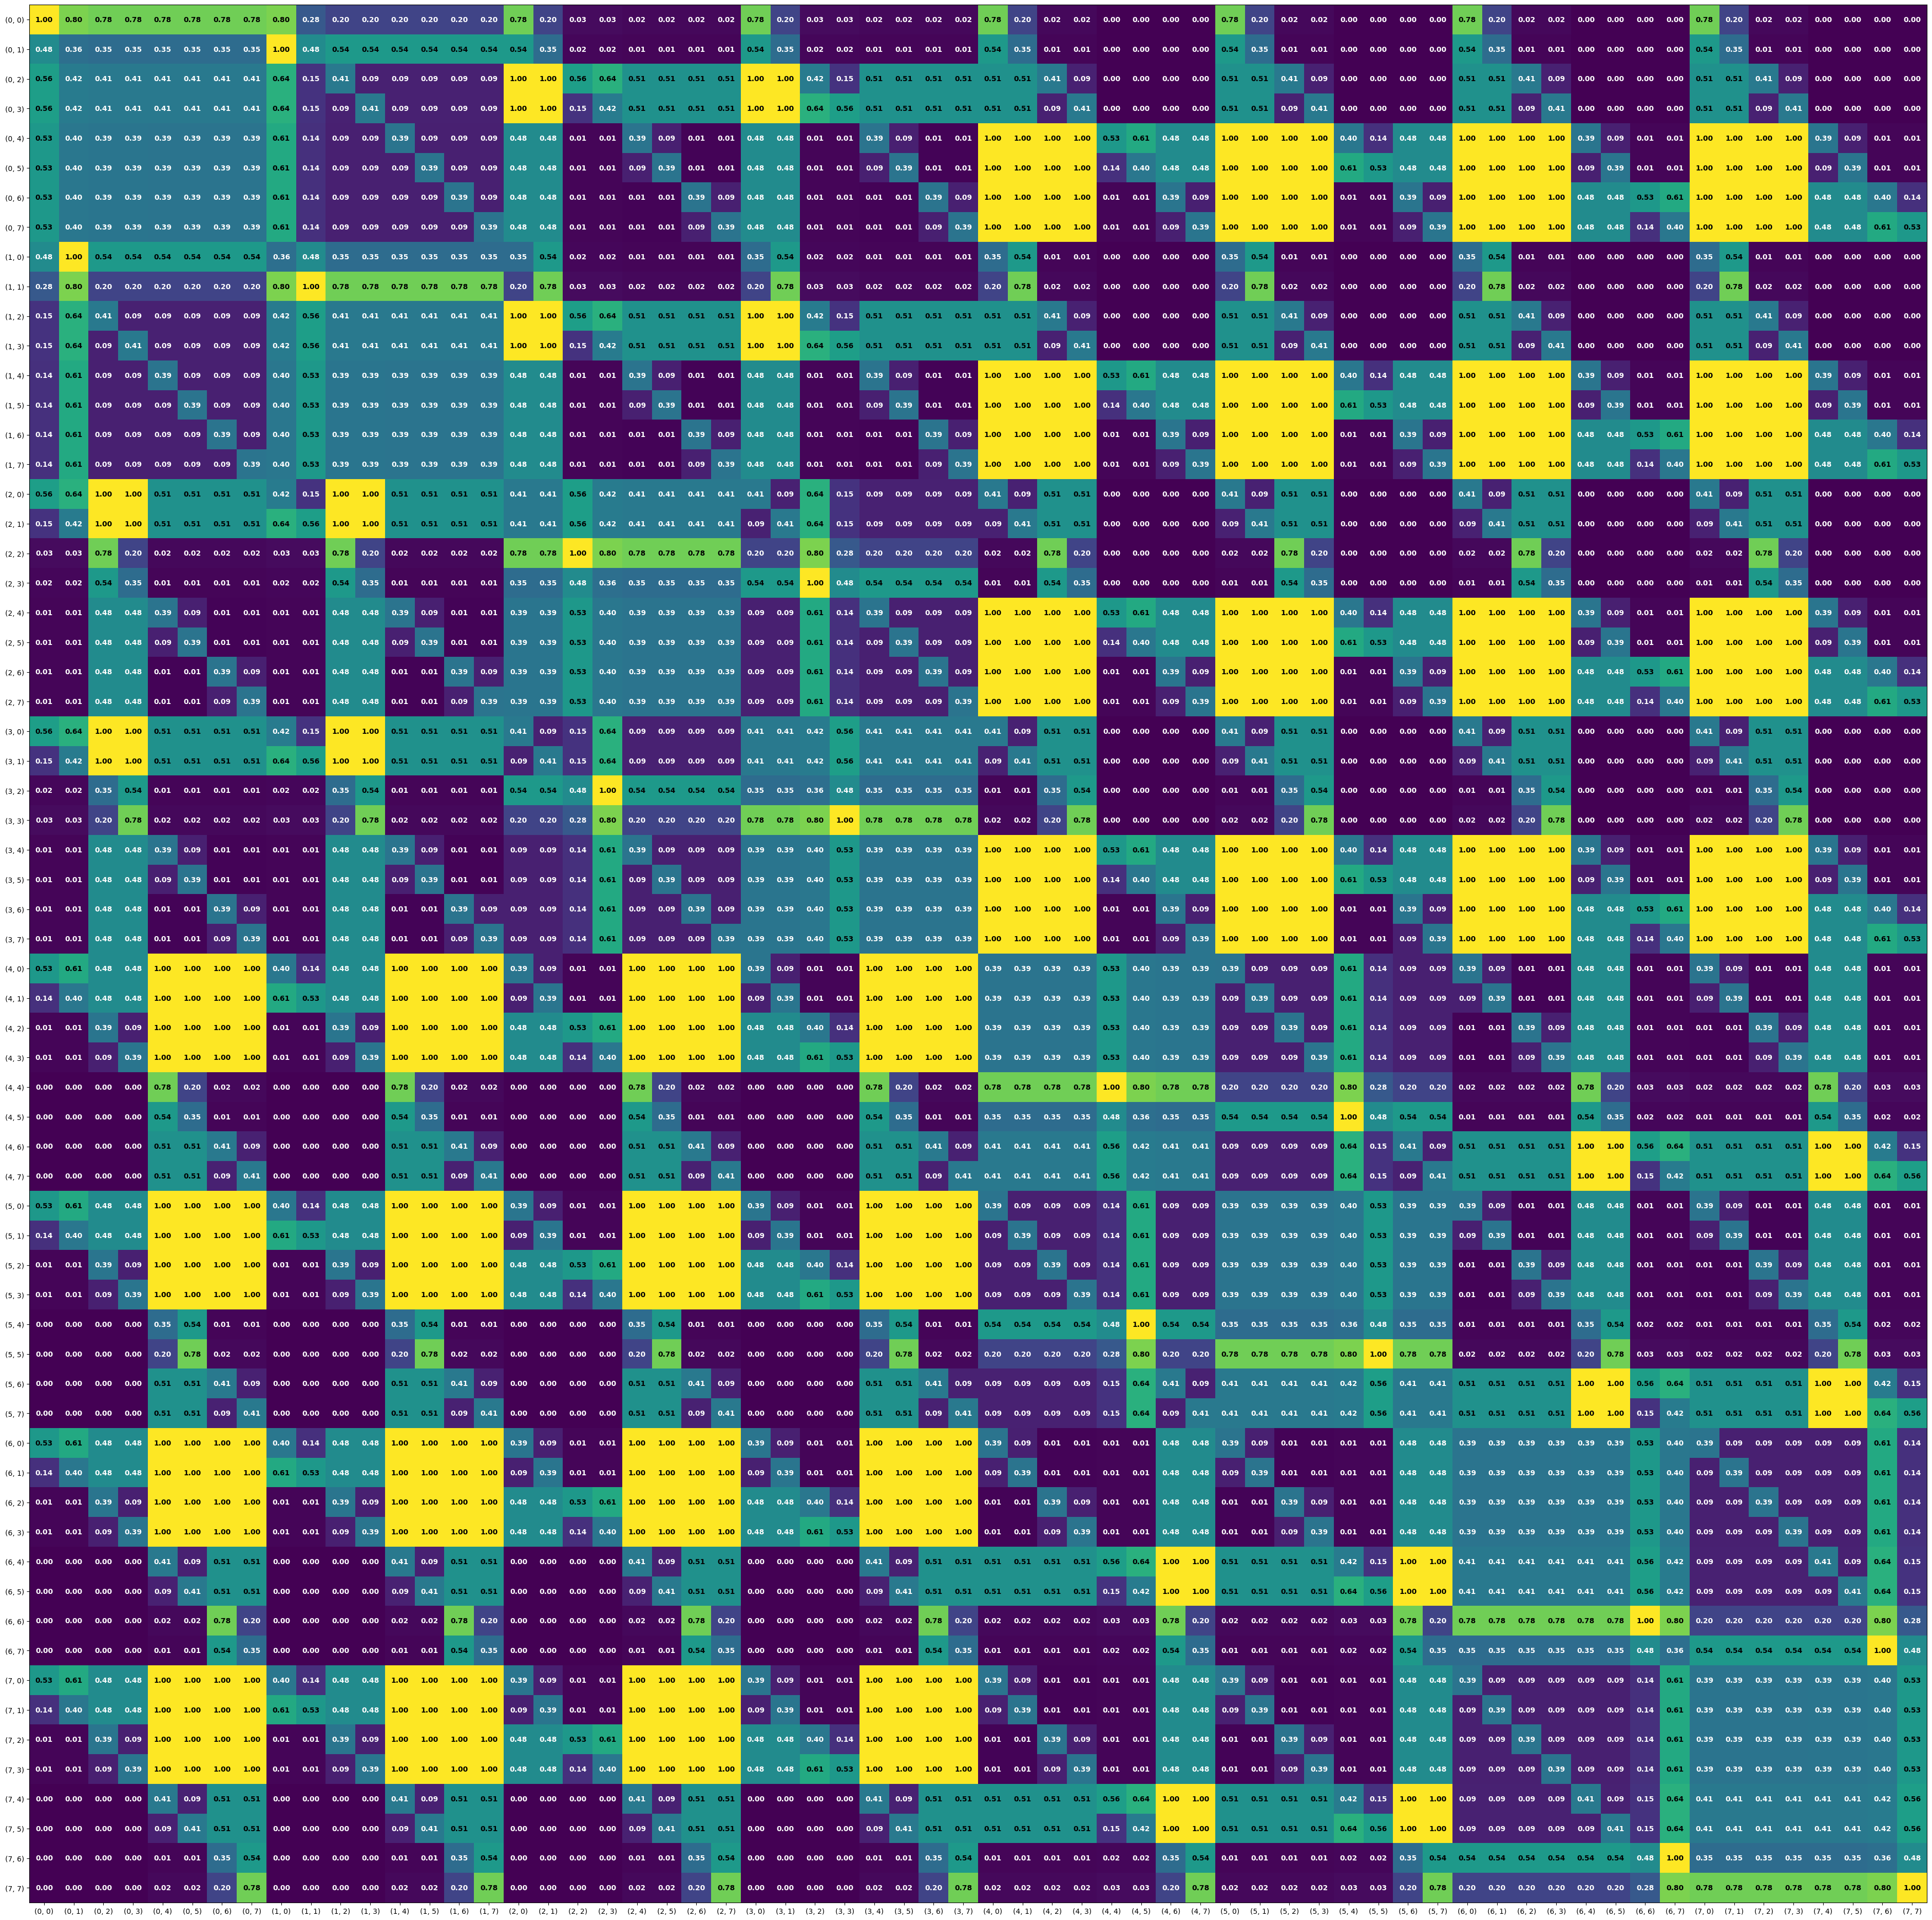

In [10]:
viz.fig_colored_matrix(
            hm_rowwise,
            xticks=itertools.product(range(8), repeat=2),
            yticks=itertools.product(range(8), repeat=2),
            show_colorbar=False,
            figsize=None,
            vmin=0)
plt.show()